# Libraries 📚

In [1]:
import random
import numpy as np
import easydict
from glob import glob
from natsort import natsorted
import os
from tqdm import tqdm
import pandas as pd
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torch.utils.data as data
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import math

# Random seed🌱

In [2]:
#再現性の確保
seed = 44
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #Disabling the benchmark by CUDA convolution operation(GPUを使うときの再現性の担保) (https://pytorch.org/docs/stable/notes/randomness.html)
    torch.backends.cudnn.benchmark = False 
    torch.backends.cudnn.determinstic = True

# Arguments 📗

In [2]:
args = easydict.EasyDict({
    "data_path" : "test.csv", #正解ラベルcsvファイル
        
    "model_save_path" : "check_point", # モデル保存ディレクトリ
    "model_file_name" : "model2_data40000_leaky", # モデル名

    "result_save_path" : "result_model2_data40000_leaky", # 結果保存ディレクトリ

    "data_size" : 5000,
})

# Pre Procceing 🎛

In [4]:
def pre_procceing():
    """
    平均値，標準偏差を求める

    Returns
    ----------
    mean : tuple
        データセットの画素の平均
    std : tuple
        データセットの画素の標準偏差
    """
    df_ms = pd.read_csv(f"mean_std.csv")
    mean = df_ms["mean"][0]
    std = df_ms["std"][0]

    return mean, std

In [5]:
mean, std = pre_procceing()
mean, std

(0.0412781052291393, 0.0661995336413383)

# Data set 🧰

In [6]:
class ImageTransform:
    """
    pytorchでの画像の前処理クラス
    訓練時だけ、データオーギュメンテーション(DA)ができるように、train,validで分けて書いた

    Attributes
    ----------
    mean : int
        データセットの画素値の平均値
    std : int
        データセットの画素値の標準偏差
    """   

    def __init__(self, mean, std):
        self.data_transform = {
            'train':transforms.Compose([
                #transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std) 
            ]),
            'valid':transforms.Compose([
                #transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    #引数なしで呼ばれたときの挙動を定義
    def __call__(self, img, phase='valid'):
        return self.data_transform[phase](img)

In [7]:
class Image_Dataset(data.Dataset):
    """
    画像のデータセットクラス。
    Pytorch Dataset class を継承

    Attributes
    ----------
    file_list : list
        画像のpath_list
    label_list : list
        ラベルのpath_list       
    transform : object
        class ImageTransform()    
    phase : str
        'train' or 'valid'
    """

    def __init__(self, df, transform, phase='train'):
        self.file_list = df["fname"] 
        self.labels = df[["dx","dy"]].to_numpy()
        self.l = df["l"]
        self.transform = transform  
        self.phase = phase  

    #このクラスの画像枚数を定義。
    def __len__(self):
        return len(self.file_list) 

    #このクラスに角括弧でアクセスした時の挙動を定義
    def __getitem__(self, index):
        # 画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)
        #img = img.convert("L") #グレイスケール 
        # 前処理
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([width, height]) 

        #label
        label = self.labels[index]
        #Tensorに変換
        label = torch.tensor(label, dtype=torch.float32) 

        # ワーキングディスタンス
        l = self.l[index]           

        return img_transformed, label, #l

# NetWork 🧠

In [8]:
# # 残差ブロック


class block(nn.Module):
    def __init__(self, first_conv_in_channels, first_conv_out_channels, identity_conv=None, stride=1):
        """
        残差ブロックを作成するクラス
        Args:
            first_conv_in_channels : 1番目のconv層（1×1）のinput channel数
            first_conv_out_channels : 1番目のconv層（1×1）のoutput channel数
            identity_conv : channel数調整用のconv層
            stride : 3×3conv層におけるstide数。sizeを半分にしたいときは2に設定
        """        
        super(block, self).__init__()

        # 1番目のconv層（1×1）
        self.conv1 = nn.Conv2d(first_conv_in_channels, first_conv_out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(first_conv_out_channels)

        # 2番目のconv層（3×3）
        # パターン3の時はsizeを変更できるようにstrideは可変
        self.conv2 = nn.Conv2d(first_conv_out_channels, first_conv_out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(first_conv_out_channels)

        # 3番目のconv層（1×1）
        # output channelはinput channelの4倍になる
        self.conv3 = nn.Conv2d(first_conv_out_channels, first_conv_out_channels*4, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(first_conv_out_channels*4)
        self.relu = nn.ReLU()

        # identityのchannel数の調整が必要な場合はconv層（1×1）を用意、不要な場合はNone
        self.identity_conv = identity_conv

    def forward(self, x):

        identity = x.clone()  # 入力を保持する

        x = self.conv1(x)  # 1×1の畳み込み
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)  # 3×3の畳み込み（パターン3の時はstrideが2になるため、ここでsizeが半分になる）
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)  # 1×1の畳み込み
        x = self.bn3(x)

        # 必要な場合はconv層（1×1）を通してidentityのchannel数の調整してから足す
        if self.identity_conv is not None:
            identity = self.identity_conv(identity)
        x += identity

        x = self.relu(x)

        return x

In [9]:
#  Resnet50

class ResNet(nn.Module):
    def __init__(self,block):
        super(ResNet,self).__init__()

        # conv1はアーキテクチャ通りにベタ打ち
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # conv2_xはサイズの変更は不要のため、strideは1
        self.conv2_x = self._make_layer(block, 3, res_block_in_channels=64, first_conv_out_channels=64, stride=1)

        # conv3_x以降はサイズの変更をする必要があるため、strideは2
        self.conv3_x = self._make_layer(block, 4, res_block_in_channels=256,  first_conv_out_channels=128, stride=2)
        self.conv4_x = self._make_layer(block, 6, res_block_in_channels=512,  first_conv_out_channels=256, stride=2)
        self.conv5_x = self._make_layer(block, 3, res_block_in_channels=1024, first_conv_out_channels=512, stride=2)

        #self.avgpool = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Identity()
        #self.fc2 = nn.Linear(224,2)

        # Regression
        self.regression = nn.Sequential(
            nn.Linear(2048, 512), 
            nn.LeakyReLU(),       
            nn.Linear(512, 128),  
            nn.LeakyReLU(),
            nn.Linear(128, 32),        
            nn.Linear(32, 2)
        )

    def forward(self,x):

        x = self.conv1(x)   # in:(3,224*224)、out:(64,112*112)
        x = self.bn1(x)     # in:(64,112*112)、out:(64,112*112)
        x = self.relu(x)    # in:(64,112*112)、out:(64,112*112)
        x = self.maxpool(x) # in:(64,112*112)、out:(64,56*56)

        x = self.conv2_x(x)  # in:(64,56*56)  、out:(256,56*56)
        x = self.conv3_x(x)  # in:(256,56*56) 、out:(512,28*28)
        x = self.conv4_x(x)  # in:(512,28*28) 、out:(1024,14*14)
        x = self.conv5_x(x)  # in:(1024,14*14)、out:(2048,7*7)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        #x = self.fc2(x)

        x = self.regression(x)

        return x

    def _make_layer(self, block, num_res_blocks, res_block_in_channels, first_conv_out_channels, stride):
        layers = []

        # 1つ目の残差ブロックではchannel調整、及びsize調整が発生する
        # identifyを足す前に1×1のconv層を追加し、サイズ調整が必要な場合はstrideを2に設定
        identity_conv = nn.Conv2d(res_block_in_channels, first_conv_out_channels*4, kernel_size=1,stride=stride)
        layers.append(block(res_block_in_channels, first_conv_out_channels, identity_conv, stride))

        # 2つ目以降のinput_channel数は1つ目のoutput_channelの4倍
        in_channels = first_conv_out_channels*4

        # channel調整、size調整は発生しないため、identity_convはNone、strideは1
        for i in range(num_res_blocks - 1):
            layers.append(block(in_channels, first_conv_out_channels, identity_conv=None, stride=1))

        return nn.Sequential(*layers)

# Test & Evalation 🧐

In [10]:
model = ResNet(block)
# load weights
model.load_state_dict(torch.load(os.path.join(args.model_save_path,args.model_file_name+".pth")))
model.eval()

test_df = pd.read_csv(args.data_path)

mean, std = pre_procceing()

transform = ImageTransform(mean, std)

test_dataset = Image_Dataset(df=test_df[:args.data_size], transform=transform, phase='valid')
test_dataloader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    pin_memory=True,
    shuffle=False,
    )

pred = np.zeros((args.data_size, 2))
test_correct=np.zeros((args.data_size, 2))

for i, minibatch in enumerate(tqdm(test_dataloader)):
    inputs, labels = minibatch
    regression_output_ = model(inputs)
    regression_output = regression_output_.detach()
    pred[i] = regression_output.numpy()
    test_correct[i] = labels.numpy()

print(f'Model prediction {pred[-5:]}')
print(f'Label {test_correct[-5:]}')

100%|██████████| 5000/5000 [06:39<00:00, 12.52it/s]

Model prediction [[ 5.25996208  1.35900605]
 [-1.10072052  1.92055535]
 [ 1.69045722  0.93921947]
 [-1.41578329 -4.73284101]
 [ 6.6832757  -2.52727532]]
Label [[ 5.25206614  1.05190969]
 [-1.128016    2.58193398]
 [ 1.88110101  0.73267806]
 [-1.27313244 -2.40915346]
 [ 6.13829708 -1.63022017]]


In [11]:
# 予測結果保存
os.makedirs(os.path.join(args.result_save_path),exist_ok=True)
result_df = pd.DataFrame(np.hstack((pred,test_correct)),columns=['pred_x','pred_y','label_x','label_y'])
result_df["L"] = test_df["l"][:args.data_size]
prediction_result_save_path = os.path.join(args.result_save_path,f'prediction_result.csv')
result_df.to_csv(prediction_result_save_path, index=False)

In [12]:
result_df = pd.read_csv(prediction_result_save_path)
pred = result_df[['pred_x','pred_y']].to_numpy()
test_correct = result_df[['label_x','label_y']].to_numpy()

In [13]:
ls = np.loadtxt(prediction_result_save_path, skiprows = 1,delimiter=",")


#RMSEを計算
rmse_x = np.sqrt(np.mean((ls[:,0] - ls[:,2]) ** 2))
rmse_y = np.sqrt(np.mean((ls[:,1] - ls[:,3]) ** 2))

#誤差の最大値を計算
E_max_x = np.max(ls[:,0]-ls[:,2])
E_max_y = np.max(ls[:,1]-ls[:,3])

#推定値の平均値（バイアス）
ave_x = np.average(ls[:,0])
ave_y = np.average(ls[:,1])


a = pd.DataFrame({"RMSE X[um]":rmse_x,"RMSE Y[um]":rmse_y,"Error Max X[um]":E_max_x,"Error Max Y[um]":E_max_y,"Pred Ave X[um]":ave_x,"Pred Ave Y[um]":ave_y},index=['',])
a = a.round(2)
a.to_csv(os.path.join(args.result_save_path,"RMSE_and_Ave.csv"))

In [14]:
class Draw_chart:
    """
    グラフ描画クラス

    Attributes
    ----------
    pred : array
        モデルの予測
    test_correct : array
        Label       
    axis : str
        x or y
    """

    def __init__(self, pred, test_correct, axis):
        self.pred = pred
        self.label= test_correct
        self.error = pred - test_correct
        #self.rmse = np.sqrt(sum((self.error)**2)) / len()
        if axis == 'x':
            self.axis = 0
            self.x_y = 'X'
            self.color  = '#28598F'
            self.ave = ave_x
        elif axis == 'y':
            self.axis = 1
            self.x_y = 'Y'
            self.ave = ave_y
            self.color  = '#ee7800'

        #グラフ保存先
        os.makedirs(os.path.join(args.result_save_path), exist_ok=True)
        
        

    def histplot(self):
        sns.set_theme(rc={'font.family':'Times New Roman'})
        use_col = pd.Series(self.error[:,self.axis])
        #スタージェスの公式
        bins = round(1 + math.log2(len(use_col)))
        p = sns.histplot(use_col, bins=bins, kde=False, color=self.color)
        p.set_xlabel(f"Error {self.x_y} [μm]", fontsize=15,weight="bold")
        p.set_ylabel("Frequency", fontsize=15,weight="bold")
        p.set_title("σ={:.2f}".format(use_col.std()), fontsize=20,weight="bold")
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        #p.set(xlim = (-10,10))
        plt.savefig(os.path.join(args.result_save_path,f'hist_{self.x_y}.png'), bbox_inches='tight')

    def histplot_expansion(self):
        sns.set_theme(rc={'font.family':'Times New Roman'})
        use_col = pd.Series(self.error[:,self.axis])
        #スタージェスの公式
        bins = round(1 + math.log2(len(use_col)))
        p = sns.histplot(use_col, bins=bins, kde=False, color=self.color)
        p.set_xlabel(f"Difference {self.x_y} [μm]", fontsize=20,weight="bold")
        p.set_ylabel("Frequency", fontsize=20,weight="bold")
        p.set_title("σ = {:.2f} ,  μ = {:.2f}".format(use_col.std(), self.ave), fontsize=25,weight="bold")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        p.set(xlim = (-3,3))
        plt.savefig(os.path.join(args.result_save_path,f'hist_{self.x_y}_expansion.png'), bbox_inches='tight')

    def scatterplot(self):
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
        plt.xlabel("Index of Test data",weight="bold",fontsize=15) # Xaxis label and display in bold
        plt.ylabel(f"d{self.x_y} [μm]",weight="bold",fontsize=15)
        plt.xlim((0,len(pred)))
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.grid(linestyle="--")
        plt.scatter(x = range(len(self.label)),y = self.label[:,self.axis],marker="o", color=self.color) #2022_10_28竹岡追記
        plt.scatter(x = range(len(self.pred)),y = self.pred[:,self.axis],marker="o", color="#3CB371", alpha=1) #2022_10_28竹岡追記
        plt.legend(labels=["Label","Model Prediction"],bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=15)
        plt.savefig(os.path.join(args.result_save_path,f'scatter_{self.x_y}.png'), bbox_inches='tight')
        plt.show()

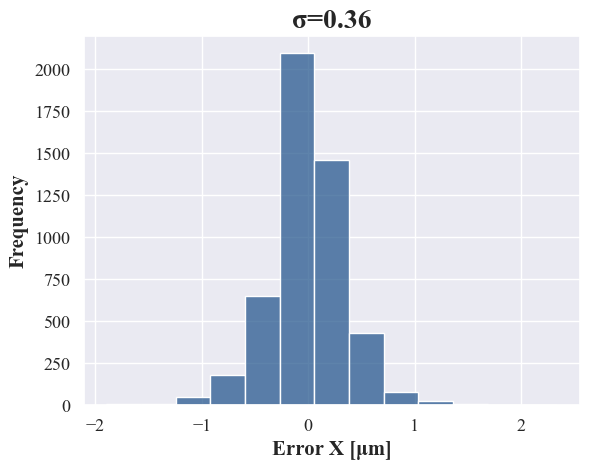

In [15]:
Draw_chart(pred,test_correct,'x').histplot()


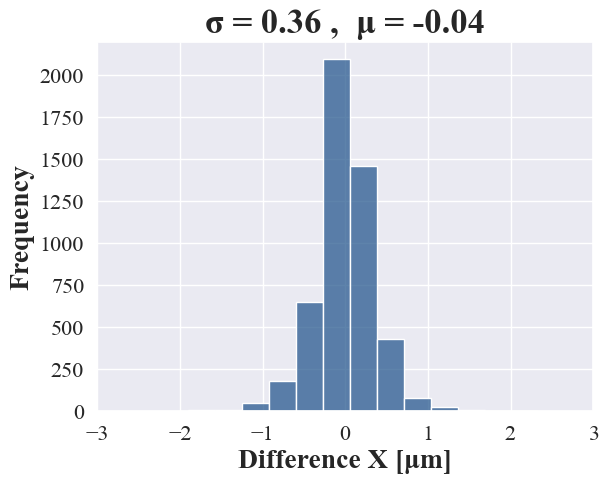

In [16]:
Draw_chart(pred,test_correct,'x').histplot_expansion()

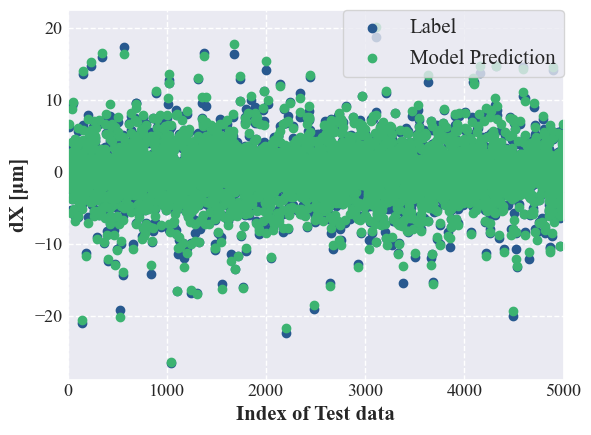

In [17]:
Draw_chart(pred,test_correct,'x').scatterplot()

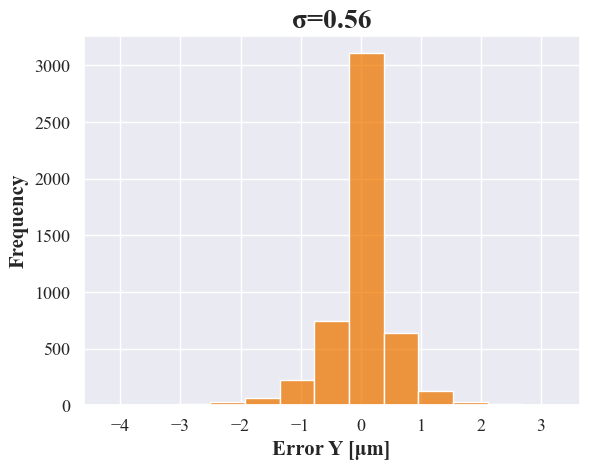

In [18]:
Draw_chart(pred,test_correct,'y').histplot()

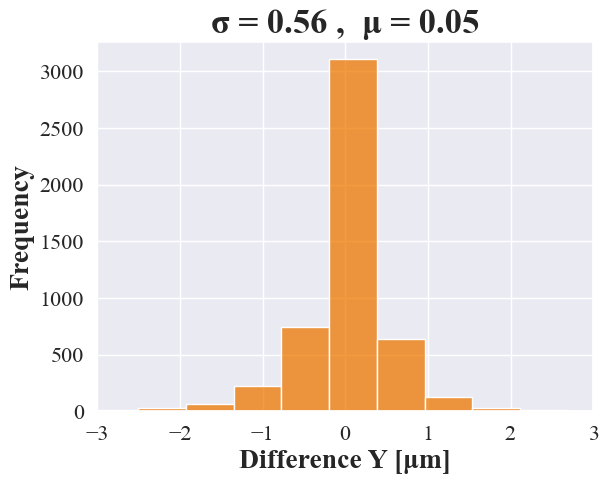

In [19]:
Draw_chart(pred,test_correct,'y').histplot_expansion()

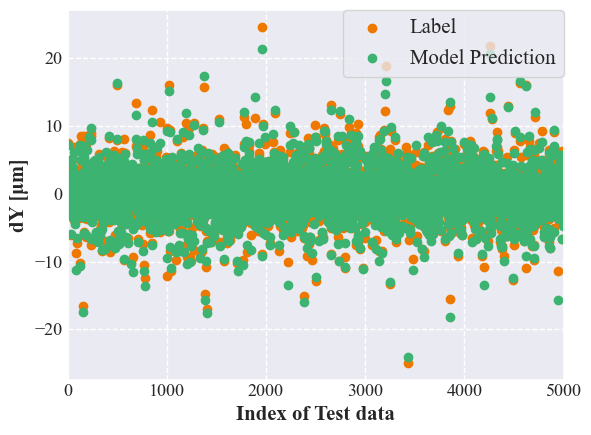

In [20]:
Draw_chart(pred,test_correct,'y').scatterplot()

終わり